In [105]:
import json
import re
import numpy as np
import nltk
import pickle
import random
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt

## Chat Bot

In [106]:
class ChatBot:
    """
    A class for creating a chatbot.

    Attributes:
        intents (dict): A dictionary of intents, where each intent is a dictionary with the following keys:
            * patterns (list): A list of patterns that the intent matches.
            * tag (str): The name of the intent.
        all_words (list): A list of all the words in the intents.
        classes (list): A list of all the intent tags.
        dataset (list): A list of tuples, where each tuple consists of a list of tokenized words and the intent tag.
        language (str): Language of the chatbot
        mode (str): Chatbot running modes
                        - development : Debugging logs will be enabled
                        - production : Debugging logs will be disabled

    Methods:
        preprocess(): Preprocesses the intents, creating the all_words and classes lists.
        create_pkl_files(): Creates the `all_words.pkl` and `classes.pkl` files.
        gen_graph(hist, title): Plots the accuracy and loss graphs for the training history.
        get_train_set(): Creates a training set from the dataset list.
        xy_split(train_set): Splits the training set into the x and y components.
        create_model(input_shape, output_shape): Creates a Keras model for training.
        train(epochs=200): Trains the Keras model.
        clean_up(sentence): Cleans up a sentence, removing punctuation and stemming the words.
        bag_of_words(sentence): Creates a bag-of-words representation of a sentence.
        get_predictions(sentence): Gets the predictions for a sentence.
    """
    IGNORED_LETTERS = ',.?!/-_'
    
    def __init__(self, language='english', json_file='./dataset/intents.json', mode='development'):
        """
        Initialize the ChatBot.

        Args:
            json_file (str): The path to the JSON file containing the intents.
        """
        self.intents = json.loads(open(json_file, encoding='utf-8').read())
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = SnowballStemmer(language='english')
        self.all_words = []
        self.classes = []
        self.dataset = []
        self.language = language
        self.mode = mode # development or production mode
        self.model_path = f'./saved_models/chat_bot_model_{self.language}'
        self.helper_file_path = './saved_data/'
        self.all_words_file_path = f'{self.helper_file_path}all_words_{self.language}.pkl'
        self.classes_file_path = f'{self.helper_file_path}classes_{self.language}.pkl'

    def preprocess(self):
        """
        Preprocess the intents data by tokenizing words and creating the dataset.
        """
        for intent in self.intents['intents']:
            for pattern in intent['patterns']:
                # Remove punctuation
                pattern = re.sub(r'[^\w\s]', '', pattern)
                # tokenize
                tokenized_words = nltk.word_tokenize(pattern)

                self.all_words.extend(tokenized_words)
                self.dataset.append((tokenized_words, intent['tag']))

                if intent['tag'] not in self.classes:
                    self.classes.append(intent['tag'])

        if self.language == 'english':
            self.all_words = [self.lemmatizer.lemmatize(word) for word in self.all_words if word not in self.IGNORED_LETTERS]
        else:
            # if sinhala language
            self.all_words = [word for word in self.all_words if word not in self.IGNORED_LETTERS]

        self.all_words = sorted(set(self.all_words))
        self.classes = sorted(set(self.classes))

    def create_pkl_files(self):
        """
        Create pickle files for all_words and classes.
        """
        pickle.dump(self.all_words, open(self.all_words_file_path, 'wb'))
        pickle.dump(self.classes, open(self.classes_file_path, 'wb'))

    def gen_graph(self, hist, title):
        """
        Generate a graph for model accuracy and loss.

        Args:
            hist: The history object returned from model.fit().
            title (str): The title of the graph.
        """
        plt.plot(hist.history['accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.show()

        plt.plot(hist.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

    def get_train_set(self):
        """
        Generate the training dataset.

        Returns:
            np.array: The training dataset.
        """
        train_set = []
        enc_arr = [0] * len(self.classes)

        for data in self.dataset:
            bag = []
            patterns = data[0]

            if self.language == 'english':
                # lemmatize words with at least two letters otherwise neglect the word
                patterns = [self.lemmatizer.lemmatize(word.lower()) for word in patterns if len(word) > 1]
            else:
                # get individual words into list if word has at least 2 letters
                patterns = [word.lower() for word in patterns if len(word) > 1]

            if self.mode == 'development':
                print('Patterns: ', patterns)

            for word in self.all_words:
                if word in patterns:
                    bag.append(1)
                else:
                    bag.append(0)

            tmp_enc_arr = list(enc_arr)
            tmp_enc_arr[self.classes.index(data[1])] = 1
            train_set.append([bag, tmp_enc_arr])
            random.shuffle(train_set)
        print(train_set)
        return np.array(train_set)

    def xy_split(self, train_set):
        """
        Split the train set into input and output.

        Args:
            train_set: The training dataset.

        Returns:
            tuple: The input and output arrays.
        """
        x_train = list(train_set[:, 0])
        y_train = list(train_set[:, 1])
        return x_train, y_train

    def create_model(self, input_shape, output_shape):
        """
        Create the model architecture.

        Args:
            input_shape: The shape of the input data.
            output_shape: The shape of the output data.

        Returns:
            Sequential: The compiled model.
        """
        model = Sequential()
        model.add(Dense(6, input_shape=input_shape, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dense(16, input_shape=input_shape, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dense(64, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dense(output_shape, activation="softmax"))

        adam = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6)

        model.compile(loss='categorical_crossentropy',
                      optimizer=adam,
                      metrics=["accuracy"])
        if self.mode == 'development':
            print(model.summary())
        return model

    def train(self, epochs=200):
        """
        Train the model.

        Args:
            epochs (int): The number of epochs to train the model for.
        """
        self.preprocess()
        self.create_pkl_files()
        train_set = self.get_train_set()

        x_train, y_train = self.xy_split(train_set)
        input_shape = (len(x_train[0]),)
        output_shape = len(y_train[0])

        model = self.create_model(input_shape, output_shape)
        hist = model.fit(x=x_train, y=y_train, epochs=epochs, verbose=1)
        if self.mode == 'development':
            title = f'Accuracy and Loss Curve of Neural Net for {self.language} Model'
            self.gen_graph(hist, title)
        model.save(self.model_path)

    def clean_up(self, sentence):
        """
        Clean up the sentence by tokenizing and stemming words.

        Args:
            sentence (str): The sentence to clean up.

        Returns:
            list: The cleaned up words.
        """
        # Remove punctuation
        sentence = re.sub(r'[^\w\s]', '', sentence)
        tokenized = nltk.word_tokenize(sentence)

        if self.language == 'english':
            cleaned_words_arr = [self.lemmatizer.lemmatize(word) for word in tokenized]
        else:
            cleaned_words_arr = [word for word in tokenized]
        return cleaned_words_arr

    def bag_of_words(self, sentence):
        """
        Convert a sentence to a bag of words representation.

        Args:
            sentence (str): The sentence to convert.

        Returns:
            np.array: The bag of words representation.
        """

        all_words = pickle.load(open(self.all_words_file_path, 'rb'))

        cleaned_words = self.clean_up(sentence)
        bag = [0] * len(all_words)

        if self.mode == 'development':
            print('All word file: ', self.all_words_file_path)
            print('Cleaned sentence: ', cleaned_words)

        for word in cleaned_words:
            for idx, w in enumerate(all_words):
                if word == w:
                    bag[idx] = 1
        return np.array(bag)

    def get_predictions(self, sentence):
        """
        Get the intent predictions for a given sentence.

        Args:
            sentence (str): The input sentence.

        Returns:
            list: A list of intent predictions with probabilities.
        """
        bag = self.bag_of_words(sentence)
        loaded_model = load_model(self.model_path)

        predictions = loaded_model.predict(np.array([bag]))[0]
        ERROR_THRESHOLD = 0.25
        results = [[i, r] for i, r in enumerate(predictions) if r > ERROR_THRESHOLD]

        classes = pickle.load(open(self.classes_file_path, 'rb'))
        results.sort(key=lambda x: x[1], reverse=True)
        return_list = []
        for result in results:
            return_list.append(
                {
                    'intent': classes[result[0]],
                    'probability': result[1]
                }
            )
        return return_list

## Testing

#### Chat Bot: English

Patterns:  ['hi']
Patterns:  ['hello']
Patterns:  ['hey']
Patterns:  ['hi', 'there']
Patterns:  ['greeting']
Patterns:  ['good', 'day']
Patterns:  ['hey', 'how', 'are', 'you']
Patterns:  ['hi', 'hows', 'it', 'going']
Patterns:  ['hello', 'nice', 'to', 'meet', 'you']
Patterns:  ['hey', 'whats', 'up']
Patterns:  ['hi', 'how', 'can', 'help', 'you']
Patterns:  ['hey', 'there', 'how', 'can', 'assist', 'you', 'today']
Patterns:  ['hello', 'how', 'may', 'be', 'of', 'service']
Patterns:  ['good', 'day', 'how', 'can', 'support', 'you']
Patterns:  ['hi', 'what', 'brings', 'you', 'here', 'today']
Patterns:  ['hey', 'nice', 'to', 'see', 'you', 'how', 'can', 'assist', 'you']
Patterns:  ['hello', 'hows', 'your', 'day', 'going']
Patterns:  ['hi', 'hows', 'everything']
Patterns:  ['hey', 'how', 'can', 'make', 'your', 'day', 'better']
Patterns:  ['hello', 'how', 'can', 'make', 'your', 'experience', 'great']
Patterns:  ['bye']
Patterns:  ['goodbye']
Patterns:  ['see', 'you']
Patterns:  ['take', 'care']


C:\Users\ACER\Documents\My mini Projects\ML\Banana Disease Prediction\venv\lib\site-packages\ipykernel_launcher.py:139: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


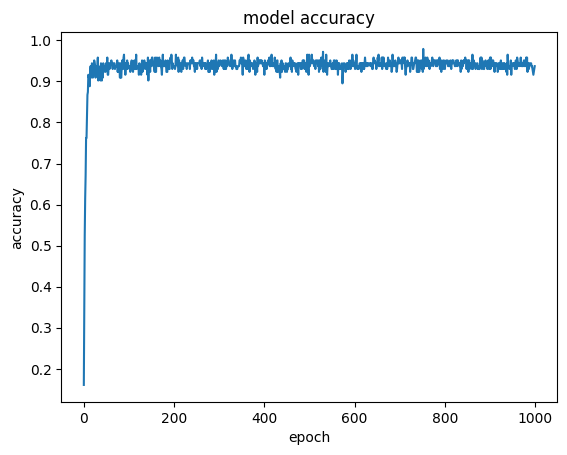

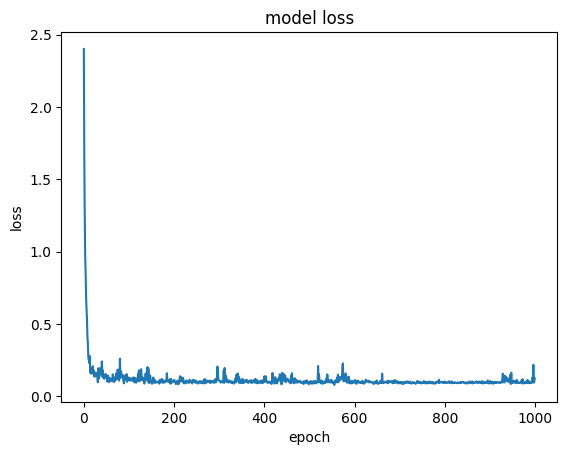

In [107]:
model = ChatBot(mode='production')
model.train(epochs=1000)

In [108]:
while True:
    msg = input('Message(press q to quit?):')
    if msg == 'q':
        break
    print(msg)
    print(model.get_predictions(msg))
    print('-----------------------------')

#### Chat Bot: Sinhala

Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns:  ['හල']
Patterns: 

C:\Users\ACER\Documents\My mini Projects\ML\Banana Disease Prediction\venv\lib\site-packages\ipykernel_launcher.py:139: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


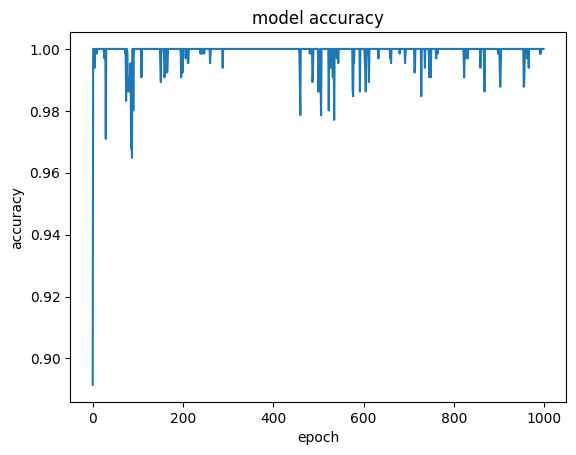

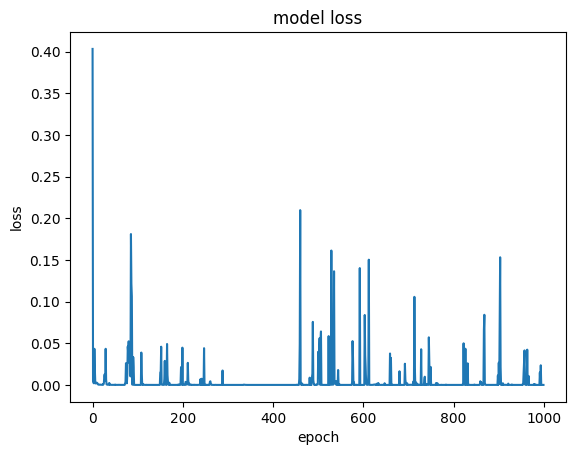

In [109]:
model = ChatBot(language='sinhala', json_file='./dataset/intents_sinhala.json', mode='production')
model.train(epochs=1000)

In [110]:
while True:
    msg = input('Message(press q to quit?):')
    if msg == 'q':
        break
    print(msg)
    print(model.get_predictions(msg))
    print('-----------------------------')


In [112]:
msg = 'හලෝ'
print(model.get_predictions(msg))

All word file:  ./saved_data/all_words_sinhala.pkl
Cleaned sentence:  ['සතතය', 'හල', 'සතතය']
[{'intent': 'thank_you', 'probability': 0.999998}]
All word file:  ./saved_data/all_words_sinhala.pkl
Cleaned sentence:  []
[{'intent': 'noanswer', 'probability': 1.0}]
All word file:  ./saved_data/all_words_sinhala.pkl
Cleaned sentence:  ['පලබධය', 'හදනනන']
[{'intent': 'Identify_diseases_by_symptoms', 'probability': 0.99904734}]
All word file:  ./saved_data/all_words_sinhala.pkl
Cleaned sentence:  ['පළබධ', 'පලනය', 'කරනන']
[{'intent': 'management_strategies', 'probability': 1.0}]
All word file:  ./saved_data/all_words_sinhala.pkl
Cleaned sentence:  ['දනගනමට', 'අවශයය']
[{'intent': 'noanswer', 'probability': 0.8439016}]
All word file:  ./saved_data/all_words_sinhala.pkl
Cleaned sentence:  ['සවව', 'කරනන']
[{'intent': 'noanswer', 'probability': 1.0}]


In [ ]:
msg = ''
print(model.get_predictions(msg))

In [ ]:
msg = 'පලිබෝධය හදුනන්න'
print(model.get_predictions(msg))

In [ ]:
msg = 'පළිබෝධ පාලනය කරන්න'
print(model.get_predictions(msg))

In [ ]:
msg = 'දැනගැනීමට අවශ්‍යයි'
print(model.get_predictions(msg))

In [ ]:
msg = 'සේවාව කරන්න'
print(model.get_predictions(msg))